# Classify land/water on Sentinel-1 and extract shorelines

## Load packages

In [1]:
%matplotlib inline

import os
os.environ['USE_PYGEOS'] = '0'
import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from dea_tools.coastal import model_tides, tidal_tag, pixel_tides, tidal_stats
from dea_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.raster import tide_cutoffs,load_tidal_subset
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.morphology import binary_closing, disk,diameter_closing
from datacube.utils.cog import write_cog

import itertools
from deafrica_tools.classification import predict_xr
import pickle

import warnings
warnings.filterwarnings("ignore")

from modules import lee_filter,filter_by_tide_height,load_s1_by_orbits,process_features_s1,collect_training_samples

## Set up a Dask cluster

In [2]:
client = create_local_dask_cluster(return_client=True)

<Client: 'tcp://127.0.0.1:38355' processes=1 threads=4, memory=26.21 GiB>

## Connect to the datacube

In [3]:
dc = datacube.Datacube(app="Sentinel-1 shoreline extraction")

In [4]:
# Define areas of interest: Madagarscar,Comoros
locations={'Madagascar_west':(-17.474,43.924),
           'Madagascar_south':(-25.572,45.538),
           'Tanzania':(-6.32,39.280),
           'Kenya':(-4.025,39.725),
           'Comoros':(-12.4,43.736)
          }

location=locations['Madagarscar_west']
lat=location[0]
lon=location[1]

# Combine central lat,lon with buffer to get area of interest
buffer = 0.04
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2018', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)

# whether to apply orbit filtering
s1_orbit_filtering=True

# whether to implement Lee filtering on Sentinel-1 data
lee_filtering=True

# Lee filtering size
filter_size=2

## View the selected location

In [5]:
display_map(x=lon_range, y=lat_range)

## Load and process Sentinel-1 data

In [6]:
# query S1 data
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vh','vv','mask','area'], # loading vh for experiement
    'resolution': (-20, 20),
    'output_crs':"EPSG:6933",
    'group_by':'solar_day',
    'dask_chunks':{'time': 1}
}

# load s1 by orbit
S1=load_s1_by_orbits(dc,query)

# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-1...')
S1_filtered=filter_by_tide_height(S1,tide_centre=0.0)

# preprocess S1 and extract features
ds_summaries_s1=process_features_s1(S1_filtered,filter_size=filter_size,
                                s1_orbit_filtering=s1_orbit_filtering,time_step=time_step)
print(ds_summaries_s1)


Querying and loading Sentinel-1 ascending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 1 time steps as a dask array

Querying and loading Sentinel-1 descending data...
Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 145 time steps as a dask array
Tide modelling and filtering for Sentinel-1...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 146/146 [00:00<00:00, 164.91it/s]


Applying Lee filtering using filtering size of 2 pixels...

Filtering Sentinel-1 product by orbit...


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Calculating features for Sentinel-1
Generate temporal composites...
<xarray.Dataset>
Dimensions:      (time: 4, y: 489, x: 387)
Coordinates:
  * y            (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x            (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2018-12-31 2019-12-31 ... 2021-12-31
Data variables:
    vh           (time, y, x) float32 -34.18 -35.5 -34.43 ... -16.61 -17.03
    vv           (time, y, x) float32 -19.75 -19.24 -18.94 ... -11.41 -11.38
    vv_a_vh      (time, y, x) float32 -55.29 -56.5 -54.33 ... -27.91 -28.21
    vv_m_vh      (time, y, x) float32 13.91 15.63 15.26 ... 5.151 5.125 5.874
    area         (time, y, x) float32 1.21 1.21 1.209 ... 1.217 1.203 1.176
    vh_std       (time, y, x) float32 7.462 6.171 5.545 ... 3.385 2.809 2.233
    vv_std       (time, y, x) float32 2.053 2.204 1.952 ... 2.935 2.435 2.232
    vv_a_vh_std  (time, y, x) float32 8.151 6.97 6

## Load and process Sentinel-2 data

In [7]:
# query S2
print('\nQuerying Sentinel-2 data...')
query.update({'measurements': ['red', 'green', 'blue', 'swir_1','nir']})
S2 = load_ard(dc=dc,
              products=['s2_l2a'],
              resampling='bilinear',
              min_gooddata=0.8,
              align=(10, 10),
              mask_filters=[("opening", 2), ("dilation", 5)],
              **query)

# Calculate S2 water index
S2 = calculate_indices(S2, index='MNDWI', satellite_mission='s2')

# per-pixel tide modelling and filtering
print('Tide modelling and filtering for Sentinel-2...')
S2_filtered=filter_by_tide_height(S2,tide_centre=0.0)

# median of S2
ds_summaries_s2 = (S2_filtered[['MNDWI']]
                .resample(time=time_step)
                .median('time')
                .compute()
                    )
print(ds_summaries_s2)


Querying Sentinel-2 data...
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 197 out of 288 time steps with at least 80.0% good quality pixels
Applying morphological filters to pq mask [('opening', 2), ('dilation', 5)]
Applying pixel quality/cloud mask
Returning 197 time steps as a dask array
Tide modelling and filtering for Sentinel-2...
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 197/197 [00:01<00:00, 166.35it/s]


<xarray.Dataset>
Dimensions:      (time: 4, y: 489, x: 387)
Coordinates:
  * y            (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
  * x            (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2018-12-31 2019-12-31 ... 2021-12-31
Data variables:
    MNDWI        (time, y, x) float32 0.5707 0.5819 0.5649 ... -0.612 -0.6232
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Plot temporal composites

In [ ]:
# Plot vh
ds_summaries_s1.vh.plot(col='time',
                       cmap='RdBu',
                       col_wrap=4,
                       robust=True, size=10)

In [ ]:
# Plot Sentinel-2
ds_summaries_s2.MNDWI.plot(col='time',
                       cmap='RdBu',
                       col_wrap=4,
                       robust=True, size=10)

### Thresholding of Sentinel-1 data (for comparison)

In [ ]:
# minimum thresholding
threshold = threshold_minimum(ds_summaries_s1.vh.values[~np.isnan(ds_summaries_s1.vh.values)])
# otsu thresholding
threshold_o = threshold_otsu(ds_summaries_s1.vh.values[~np.isnan(ds_summaries_s1.vh.values)])
print('threshold identified by minimum thresholding method: ',threshold)
print('threshold identified by otsu thresholding method: ', threshold_o)

## Apply the classification model

### Load the model

In [ ]:
with open ('rf_model_Madagarscar_west', 'rb') as file:
    rf = pickle.load(file)

### Predict each year

In [ ]:
# Rename each image by year
ds_summaries_s1['time'] = ds_summaries_s1.time.dt.year
ds_summaries_s1 = ds_summaries_s1.rename(time='year')

In [14]:
# apply to each year
predicted=[]
for i in range(ds_summaries_s1.dims['year']):
    ds_s1_year=ds_summaries_s1.isel(year=i)
    predicted_year = predict_xr(rf,ds_s1_year,proba=True,persist=False,clean=True).assign_coords(year=ds_s1_year.year.values).expand_dims('year')
    predicted.append(predicted_year)
predicted=xr.concat(predicted,dim='year')
print(predicted)

   probabilities...
predicting...
   probabilities...
predicting...
   probabilities...
predicting...
   probabilities...
<xarray.Dataset>
Dimensions:        (x: 387, y: 489, year: 4)
Coordinates:
  * x              (x) float64 4.234e+06 4.234e+06 ... 4.242e+06 4.242e+06
  * y              (y) float64 -2.191e+06 -2.191e+06 ... -2.201e+06 -2.201e+06
    spatial_ref    int32 6933
  * year           (year) int64 2018 2019 2020 2021
Data variables:
    Predictions    (year, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
    Probabilities  (year, y, x) float64 70.0 62.0 67.5 71.5 ... 66.0 71.5 83.5
Attributes:
    grid_mapping:  spatial_ref


### Plot predictions and probabilities

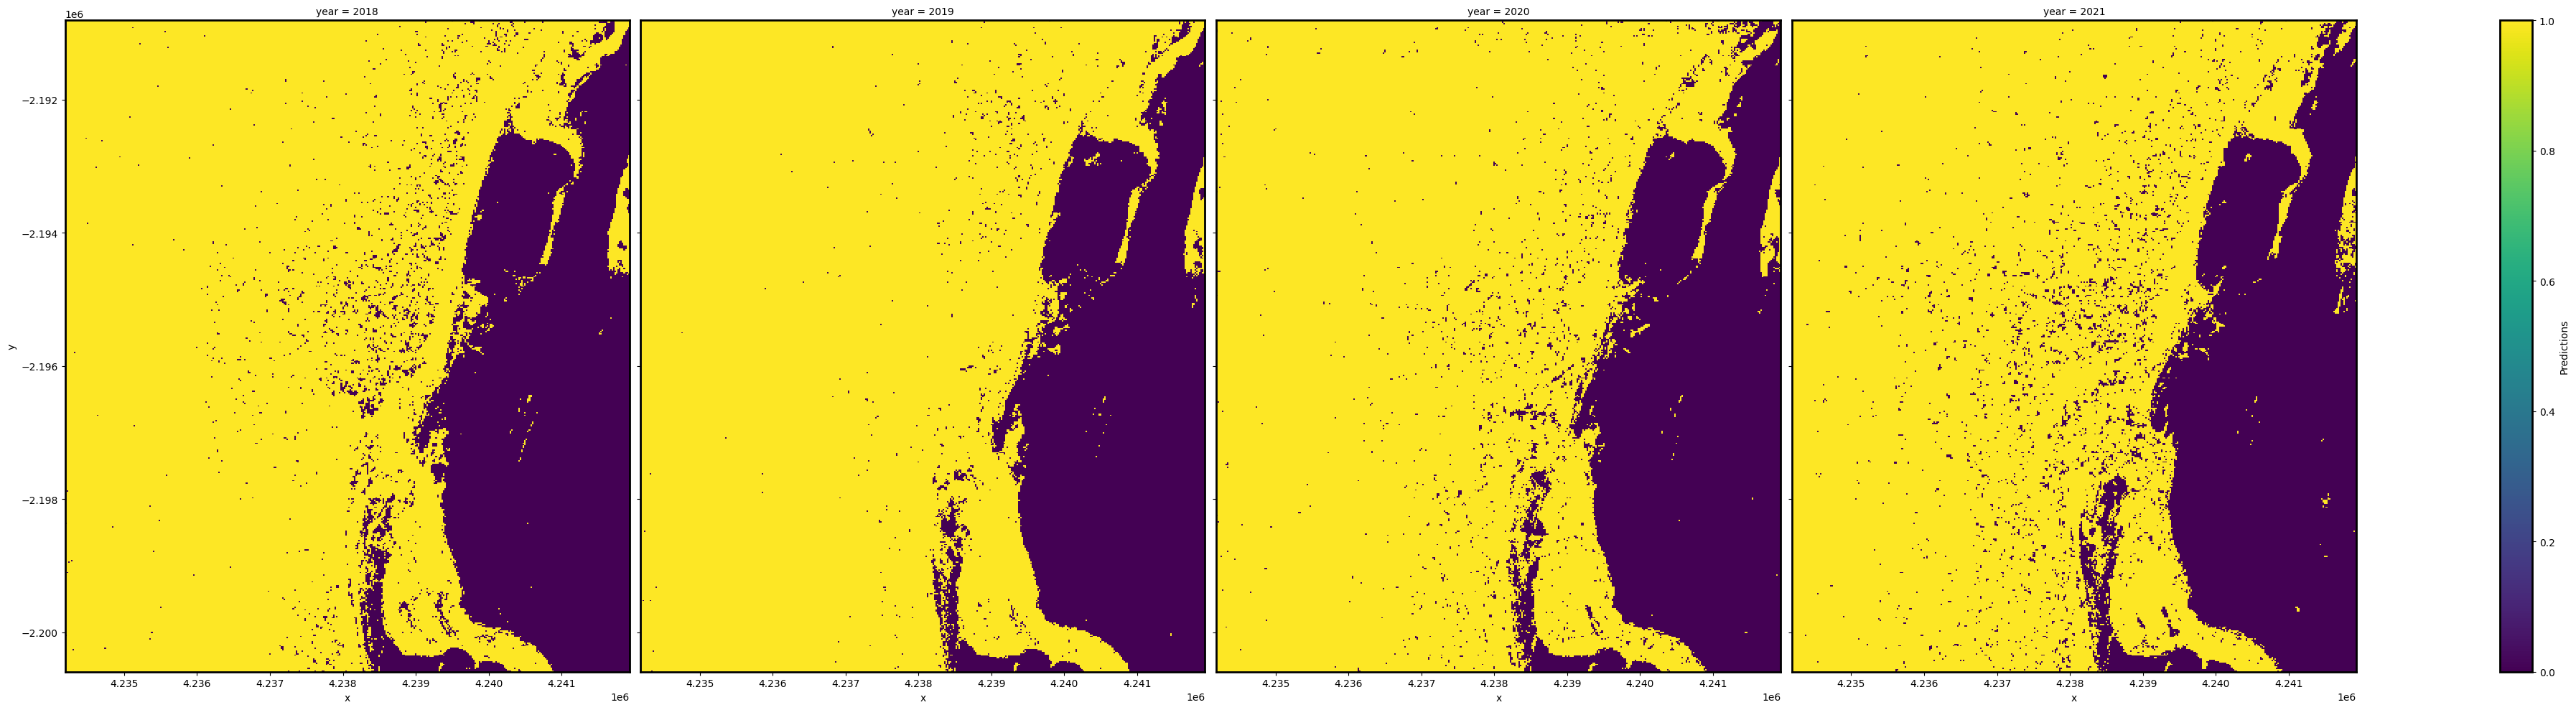

In [15]:
predicted.Predictions.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           robust=True, 
                           size=10)

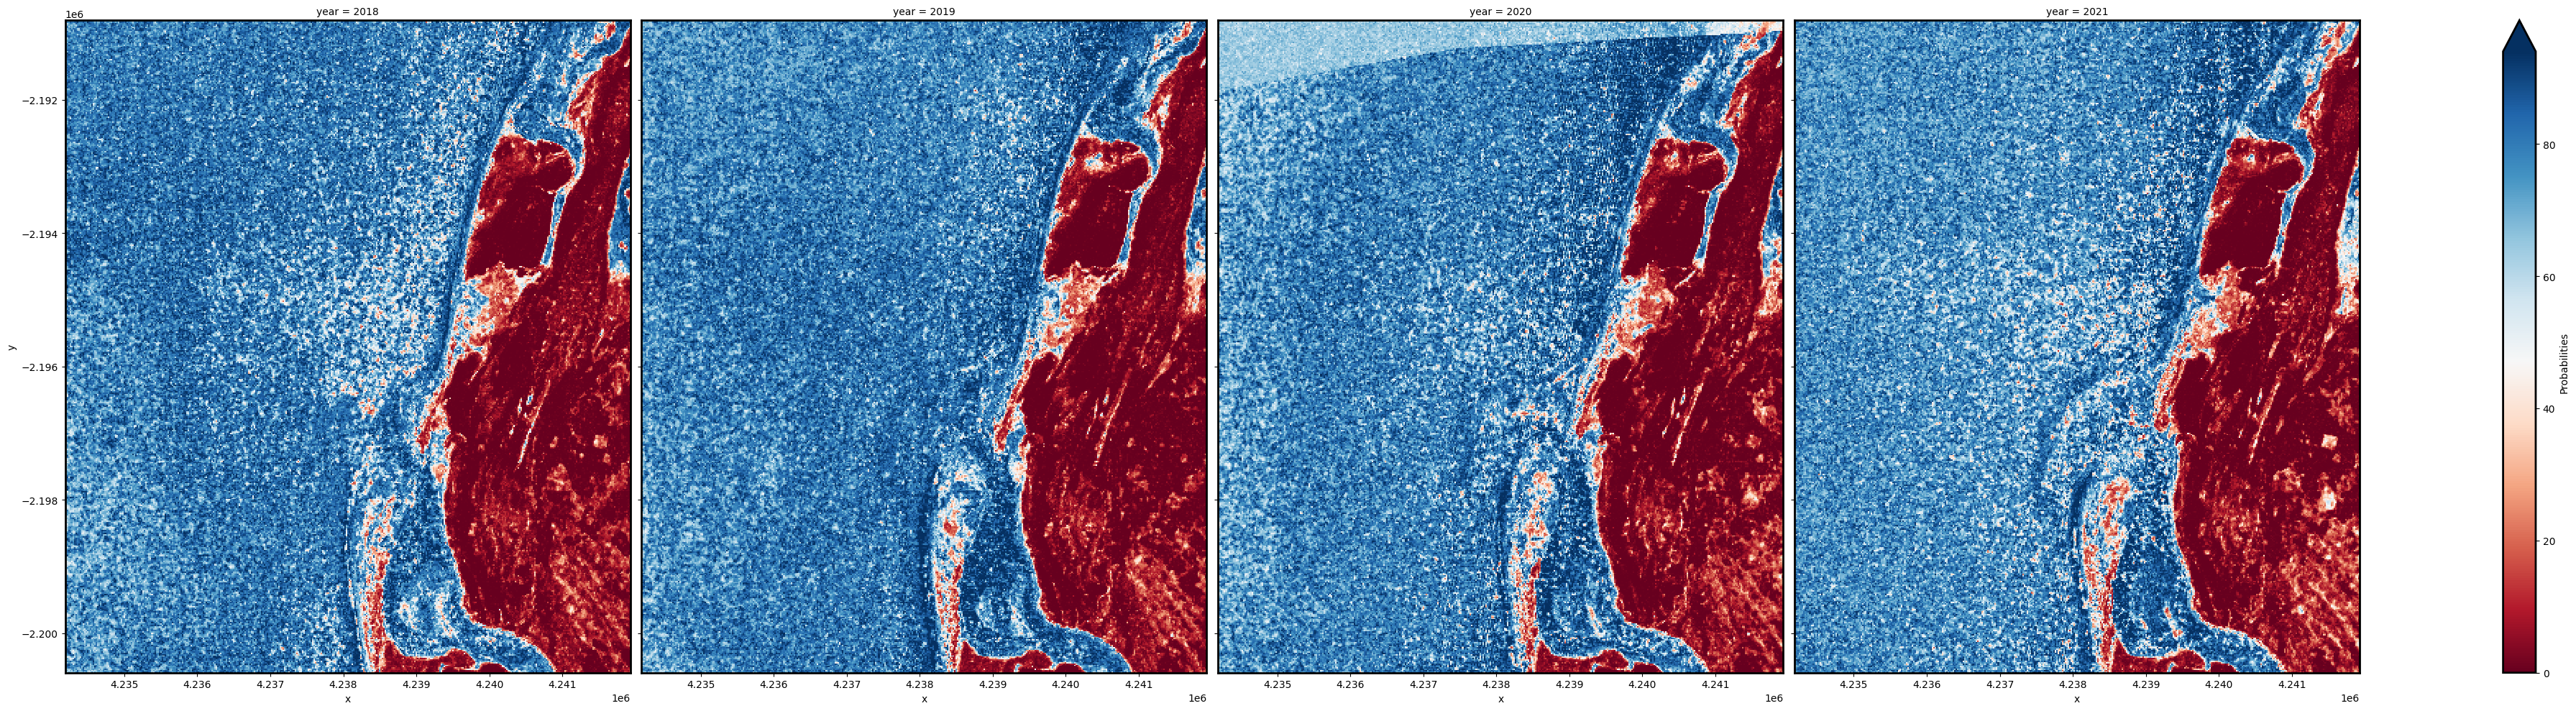

In [16]:
# covert the overall classification probabilities to water probabilities
predicted['Probabilities']=predicted.Probabilities.where(predicted.Predictions==1,100-predicted.Probabilities)
predicted.Probabilities.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)

### Spatial filtering of the predictions and probabilities

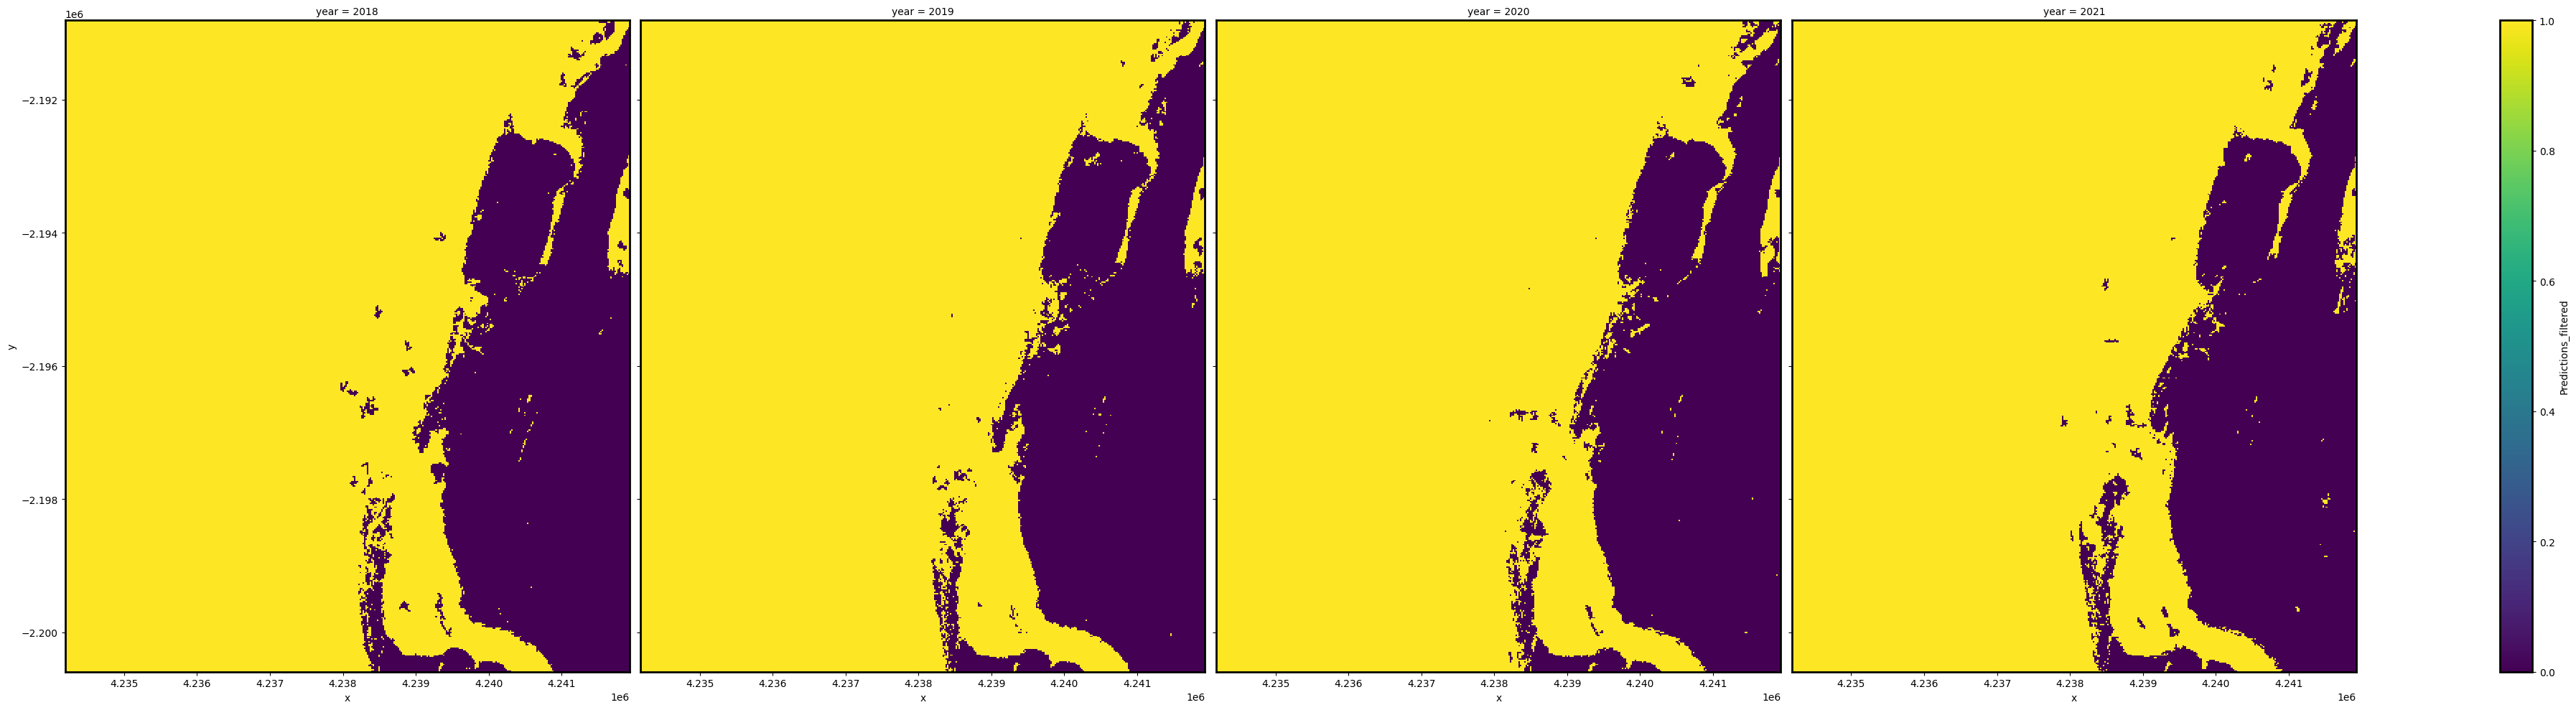

In [45]:
# predicted['Predictions_filtered']=xr.apply_ufunc(binary_closing, predicted.Predictions,disk(2))
predicted['Predictions_filtered']=xr.apply_ufunc(diameter_closing, predicted.Predictions,8)
predicted.Predictions_filtered.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)

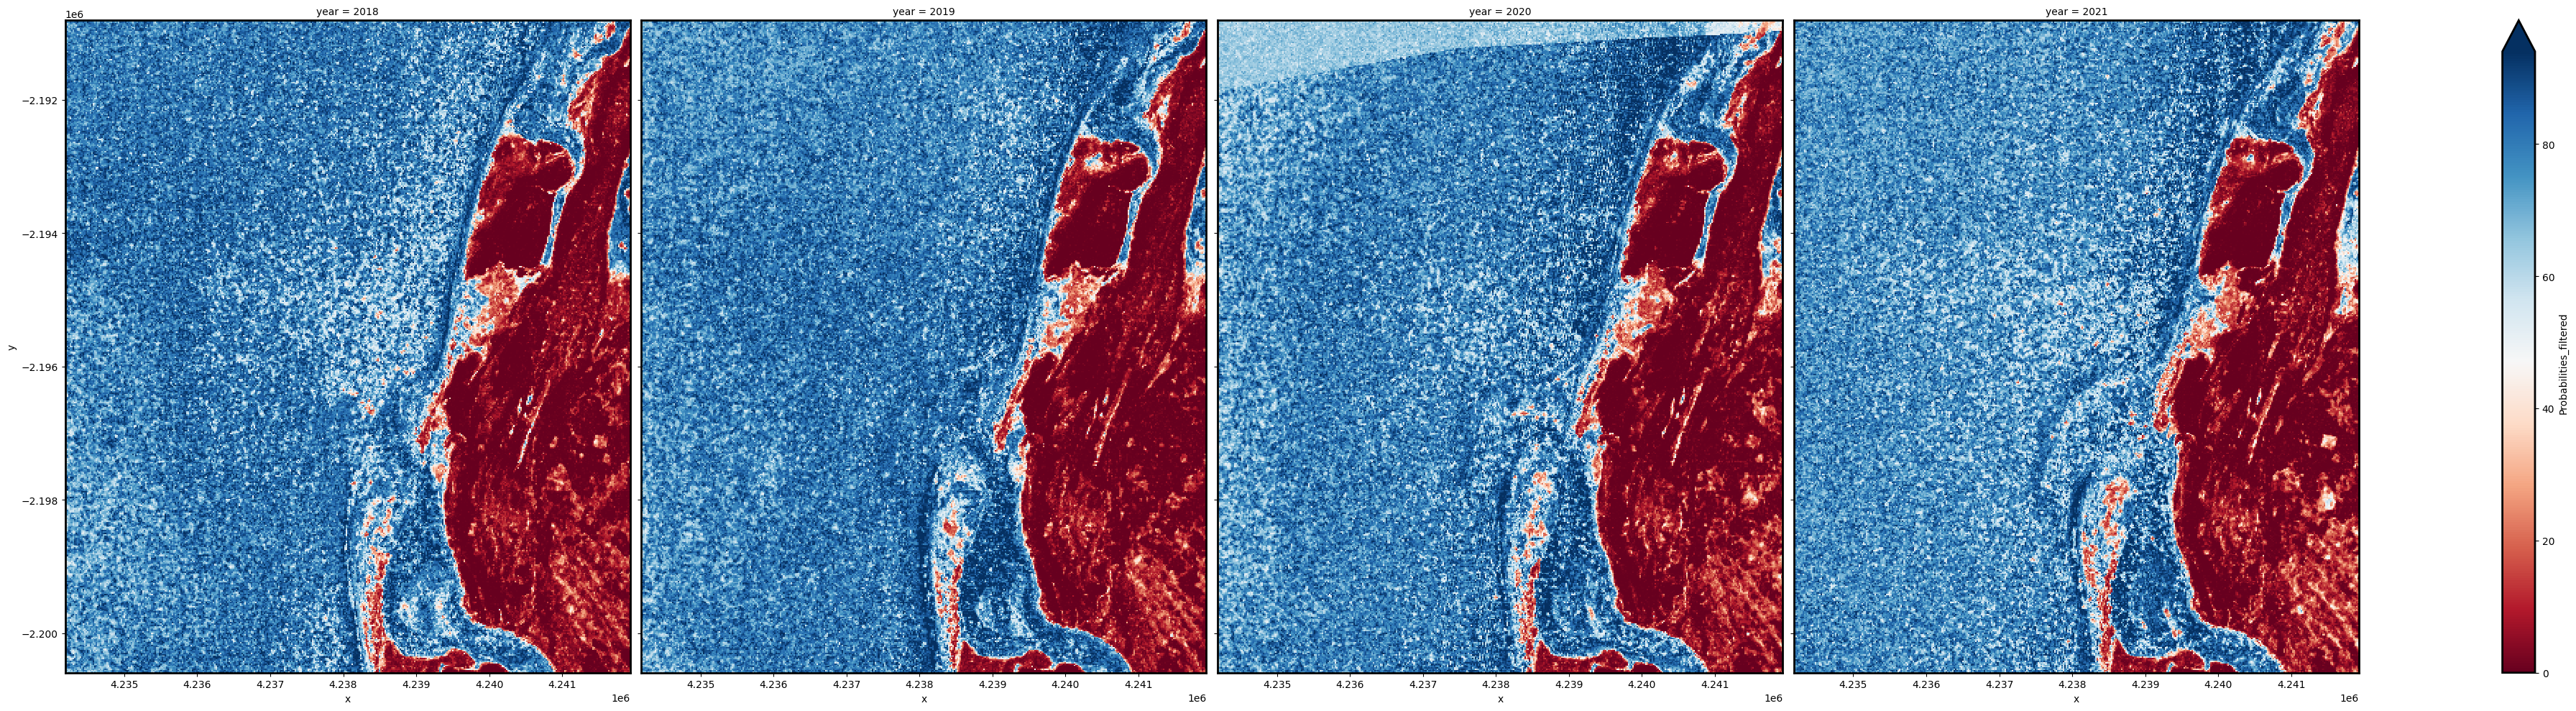

In [48]:
predicted['Probabilities_filtered']=predicted.Probabilities.where(predicted.Predictions_filtered==predicted.Predictions,
                                                                  100-predicted.Probabilities)
predicted.Probabilities_filtered.plot(col='year',
                           cmap='RdBu',
                           col_wrap=4,
                           robust=True, 
                           size=10)

### Plot classification results using thresholding (as comparison)

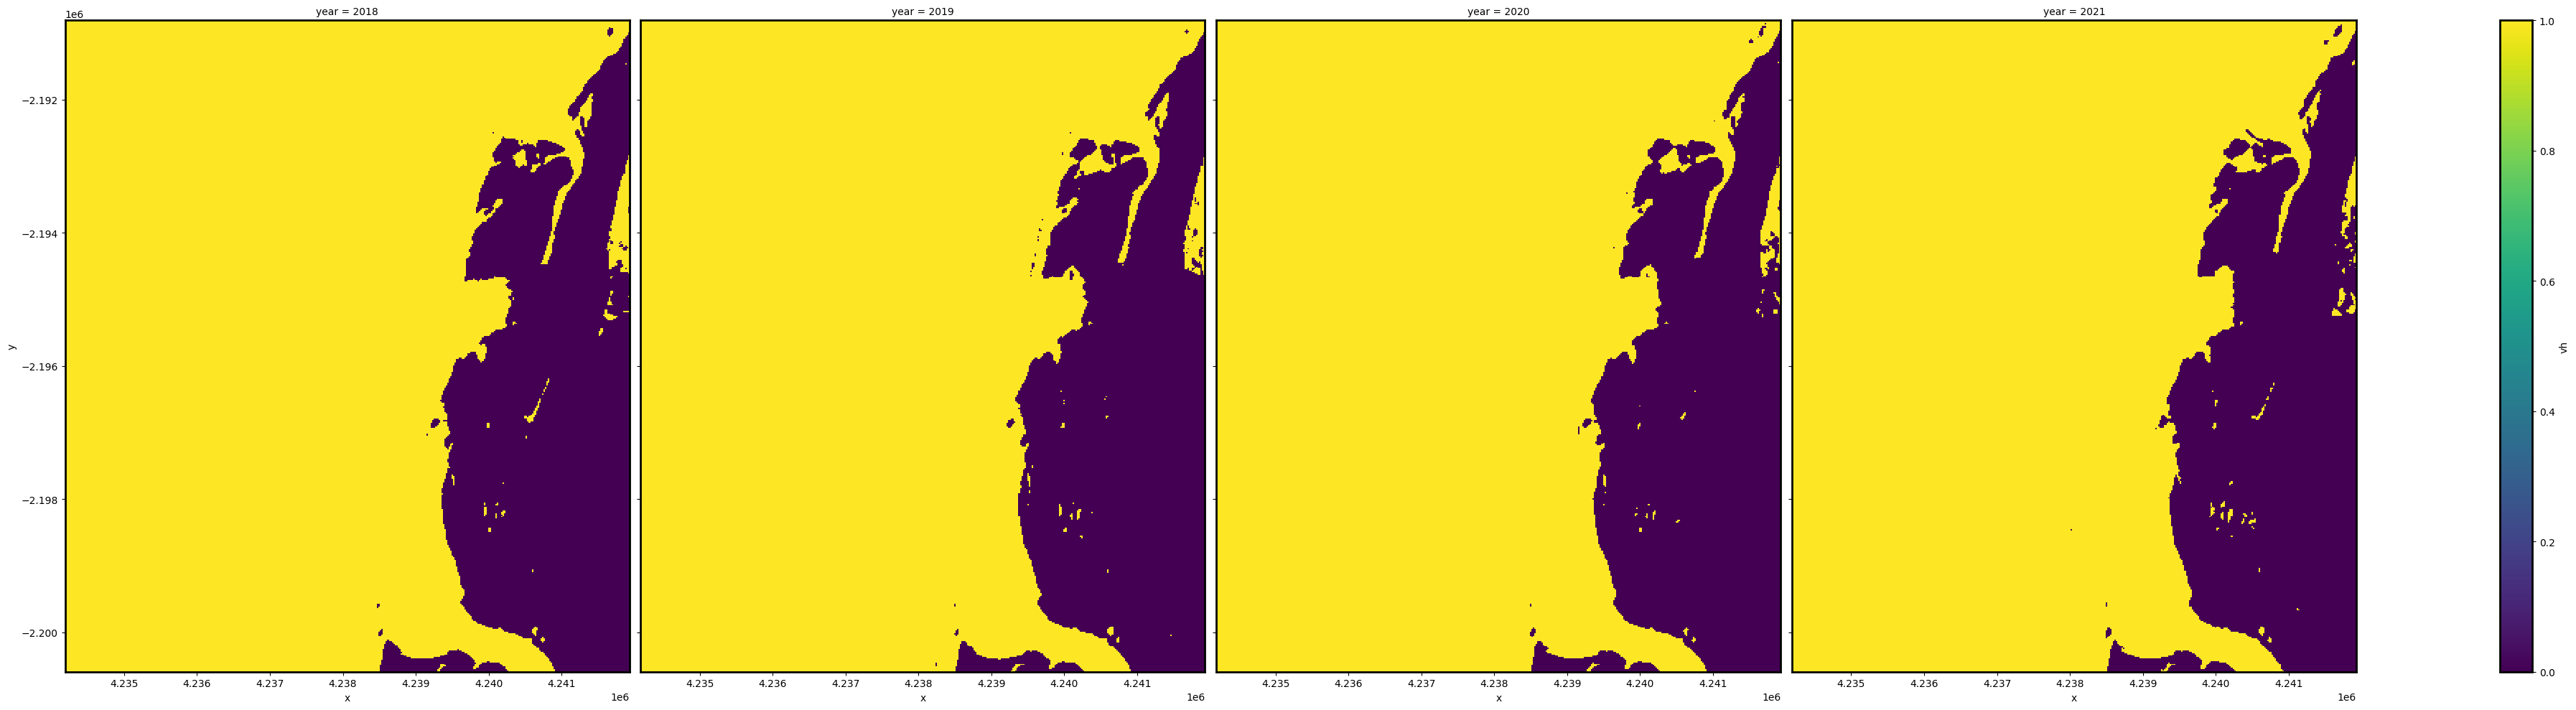

In [24]:
ds_summaries_s1_thresholded=ds_summaries_s1.vh<=threshold
ds_summaries_s1_thresholded.plot(col='year',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)

### Plot Sentinel-2 classification results (for comparison)

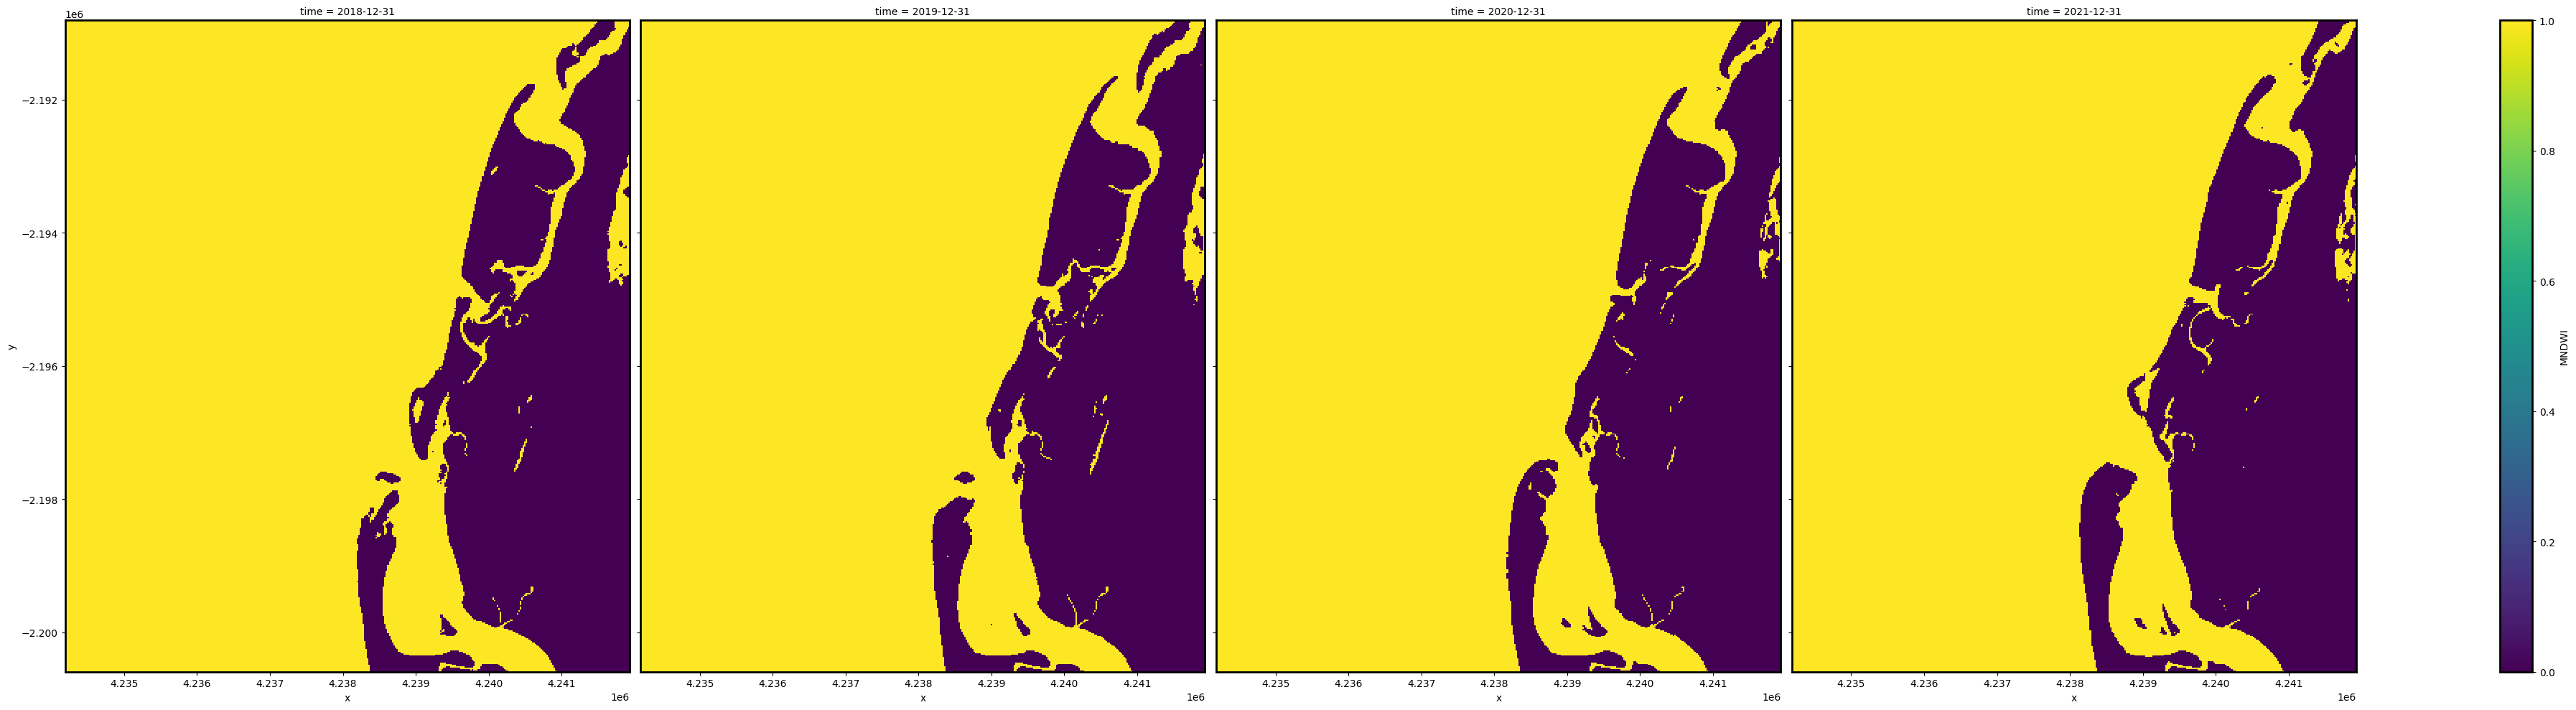

In [27]:
ds_summaries_s2_thresholded=ds_summaries_s2['MNDWI']>=0
ds_summaries_s2_thresholded.plot(col='time',
                           cmap='viridis',
                           col_wrap=4,
                           size=10)

## Extract shorelines

### Extract shorelines from prediction probabilities

In [49]:
# Extract waterline contours for the '0.5' probability:
# contour_gdf = subpixel_contours(da=predicted.Probabilities,
#                                 z_values=50,
#                                 dim='year',
#                                 crs=predicted.geobox.crs,
#                                 output_path=f'annual_shorelines_S1_supervised.geojson',
#                                 min_vertices=15).set_index('year')
contour_gdf = subpixel_contours(da=predicted.Probabilities_filtered,
                                z_values=50,
                                dim='year',
                                crs=predicted.geobox.crs,
                                output_path=f'annual_shorelines_S1_supervised_filtered.geojson',
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S1_supervised_filtered.geojson


### Extract shorelines from thresholding method (for comparison)

In [18]:
contour_gdf_thresholding=subpixel_contours(da=ds_summaries_s1.vh,
                                z_values=threshold,
                                dim='year',
                                crs=predicted.geobox.crs,
                                output_path=f'annual_shorelines_S1_thresholding.geojson',
                                min_vertices=15).set_index('year')

Operating in single z-value, multiple arrays mode
Writing contours to annual_shorelines_S1_thresholding.geojson


### Extract shorelines from Sentinel-2 data (for comparison)

In [ ]:
contour_gdf_s2=subpixel_contours(da=ds_summaries_s2['MNDWI'],
                                z_values=0,
                                dim='year',
                                crs=predicted.geobox.crs,
                                output_path=f'annual_shorelines_S2.geojson',
                                min_vertices=15).set_index('year')

### Plot annual shorelines on an interactive map

In [50]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [20]:
contour_gdf_thresholding.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [ ]:
contour_gdf_s2.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

In [ ]:
# Shut down Dask client now that we have processed the data we need
client.close()